In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error as mse
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings(
    "ignore",
    message="'force_all_finite' was renamed to 'ensure_all_finite'",
    category=FutureWarning,
    module="sklearn.utils.deprecation"
)
df=pd.read_csv('PEMS-BAY.csv',parse_dates=[0],index_col=[0])
df

,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 23:35:00,70.9,66.3,68.4,61.0,61.8,66.9,66.0,67.4,65.4,69.3,...,64.6,66.8,64.7,61.1,68.4,61.4,70.5,68.2,71.6,66.2
2017-06-30 23:40:00,71.3,66.6,68.7,60.9,62.0,66.2,66.5,68.2,64.9,69.1,...,65.1,67.3,64.8,60.8,69.8,62.2,69.4,68.6,71.6,68.4
2017-06-30 23:45:00,71.4,66.9,68.1,61.1,62.0,66.7,65.8,68.2,64.2,69.1,...,64.9,66.5,64.6,61.3,69.5,63.8,70.6,68.4,71.6,66.6
2017-06-30 23:50:00,72.2,66.5,68.0,61.1,62.5,65.8,67.1,68.3,64.0,67.3,...,64.1,65.9,64.8,61.3,69.6,64.2,70.2,68.7,71.6,68.4


In [58]:
df_fill=df.reindex(pd.date_range('2017-03-12 02:00:00', '2017-03-12 03:00:00', freq='5min'),method='ffill')
df=df_fill.combine_first(df)

In [3]:
df_train=df.loc['2017-02-26 00:00:00':'2017-05-13 23:55:00']
df_test=df.loc['2017-05-14 00:00:00':'2017-05-27 23:55:00']
df_train

,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-02-26 00:00:00,71.0,64.9,66.6,67.7,64.5,67.4,66.6,68.5,66.2,68.0,...,68.9,65.9,67.6,62.2,64.4,62.6,70.4,68.6,69.6,67.5
2017-02-26 00:05:00,71.1,64.5,66.5,67.5,64.2,67.9,67.3,67.6,66.1,68.8,...,68.6,66.0,67.7,61.9,64.7,61.9,70.1,68.7,69.9,67.3
2017-02-26 00:10:00,71.2,64.6,66.9,67.6,64.5,66.9,66.4,67.9,66.3,67.9,...,68.5,65.3,66.5,61.6,64.7,62.0,69.6,68.4,69.6,69.3
2017-02-26 00:15:00,70.7,63.4,67.2,67.5,63.1,66.9,66.9,66.8,65.8,67.2,...,68.2,65.6,66.5,61.7,64.0,62.3,70.2,68.5,69.7,68.8
2017-02-26 00:20:00,70.7,64.1,67.3,67.6,63.8,66.2,66.6,67.7,66.2,68.1,...,68.9,66.0,67.1,62.0,64.1,62.7,70.2,68.5,70.3,69.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-13 23:35:00,71.6,65.6,66.2,66.5,69.7,65.2,66.2,67.9,65.0,69.1,...,67.9,63.9,67.4,63.8,74.2,62.6,70.0,67.6,68.7,66.8
2017-05-13 23:40:00,72.1,66.0,66.9,66.6,69.7,67.2,67.3,68.8,64.0,69.3,...,68.5,64.7,66.8,63.6,73.2,61.1,69.9,68.1,69.5,67.6
2017-05-13 23:45:00,71.9,65.3,67.2,66.2,70.9,67.6,67.5,68.1,64.5,68.3,...,69.1,63.7,67.1,63.4,73.0,61.1,70.2,68.5,69.8,67.6
2017-05-13 23:50:00,72.9,65.3,67.5,67.6,70.8,67.0,66.2,67.6,64.4,67.7,...,68.7,64.4,65.9,62.2,72.9,61.7,69.9,67.5,69.8,65.7


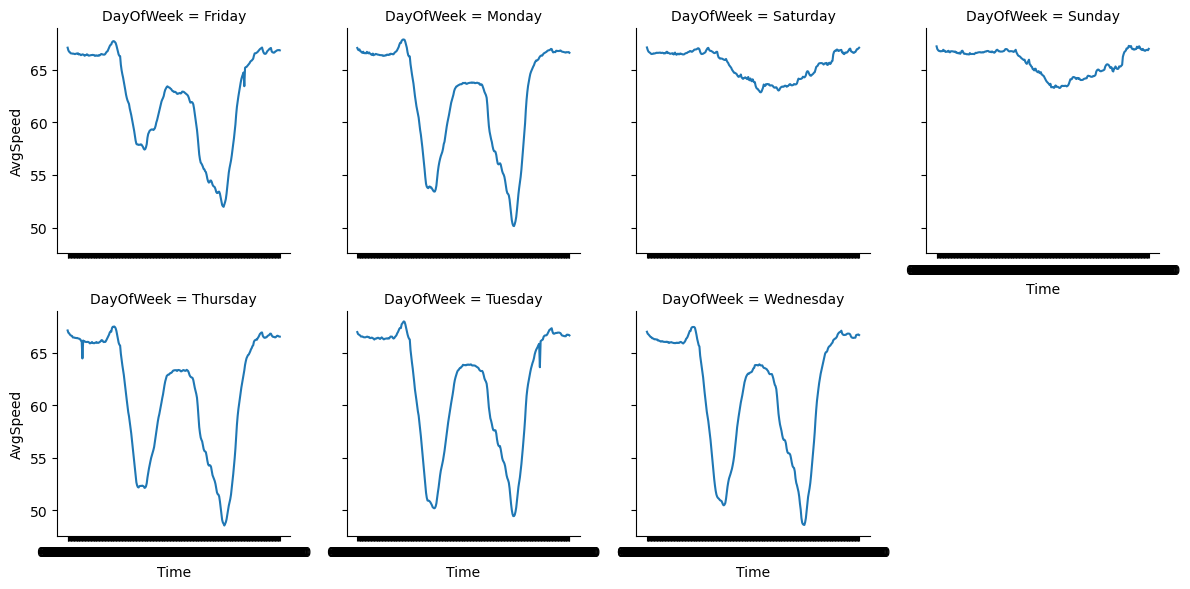

In [43]:
df_eda=df_train.copy()
df_eda['AvgSpeed']=df_eda.mean(axis=1)
df_eda['Time']=df_eda.index.time
df_eda['DayOfWeek']=df_eda.index.day_name()
grouped_avg = df_eda.groupby(['DayOfWeek', 'Time'])['AvgSpeed'].mean().reset_index()
grouped_avg['Time'] = grouped_avg['Time'].astype(str)
sns.relplot(
    data=grouped_avg,
    x='Time',
    y='AvgSpeed',
    col='DayOfWeek',
    kind='line',
    col_wrap=4,
    height=3
)
plt.tight_layout()
plt.show()

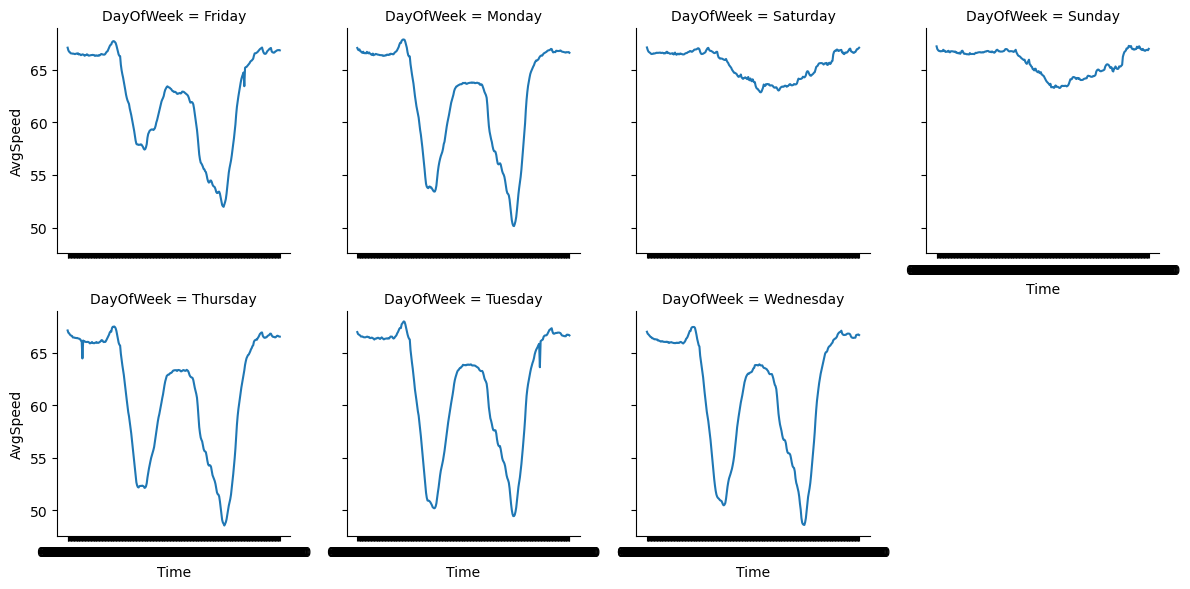

In [5]:
grouped_avg_1 = df_eda.groupby(['DayOfWeek', 'Time'])['400001'].mean().reset_index()
grouped_avg_1['Time'] = grouped_avg['Time'].astype(str)
sns.relplot(
    data=grouped_avg,
    x='Time',
    y='AvgSpeed',
    col='DayOfWeek',
    kind='line',
    col_wrap=4,
    height=3
)
plt.tight_layout()
plt.show()

In [21]:
df_train_1=df_train['400017']
model0_preds = []
model1_preds = []
model2_preds = []
model3_preds = []
df_train_1_diff=df_train_1.diff(2016).dropna()
actual=[]
for i in range(-4,1):
    ts=pd.to_datetime('2017-05-07 00:00:00')+timedelta(weeks=i)
    ts_m5=ts-timedelta(minutes=5)
    actual.append(df_train_1.loc[ts:ts_m5+timedelta(weeks=1)])

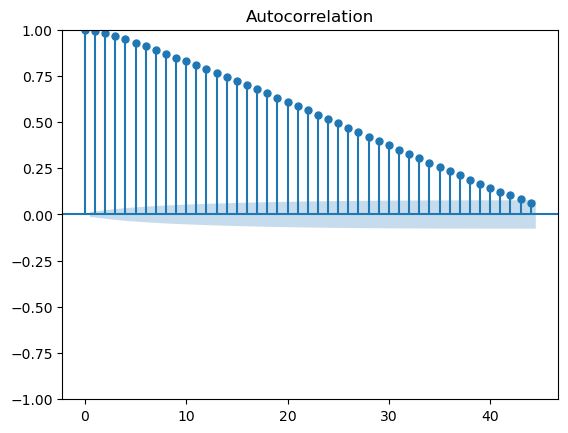

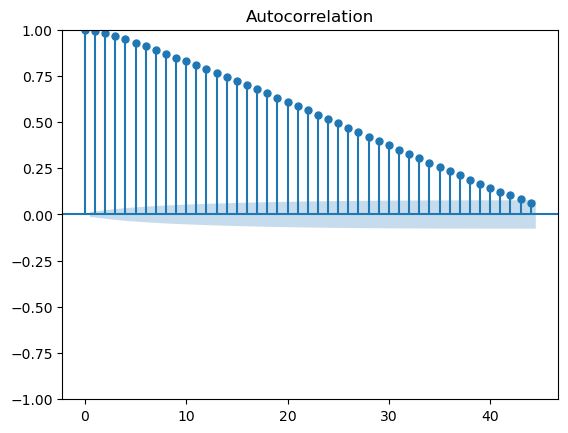

In [53]:
plot_acf(df_train_1)

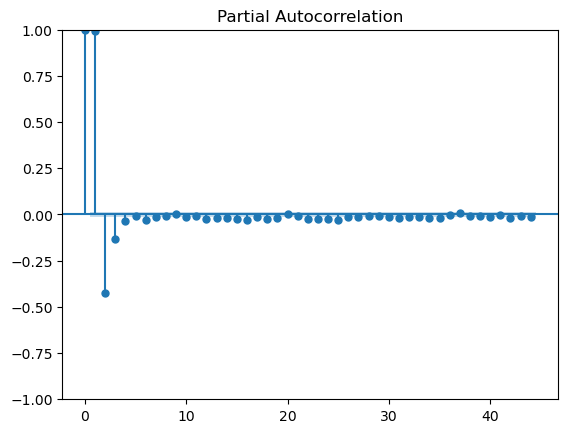

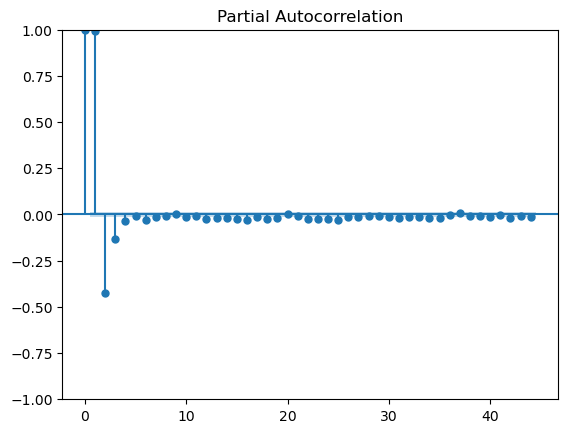

In [54]:
plot_pacf(df_train_1)

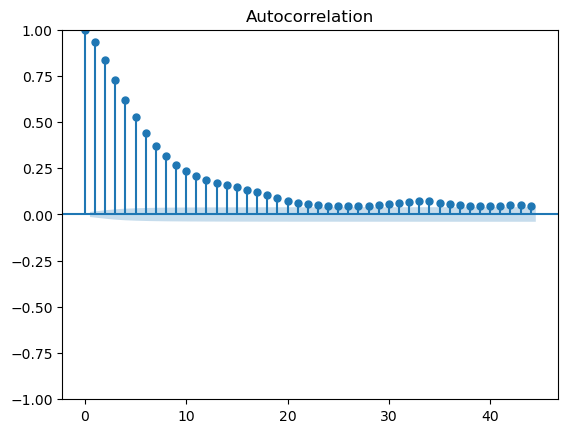

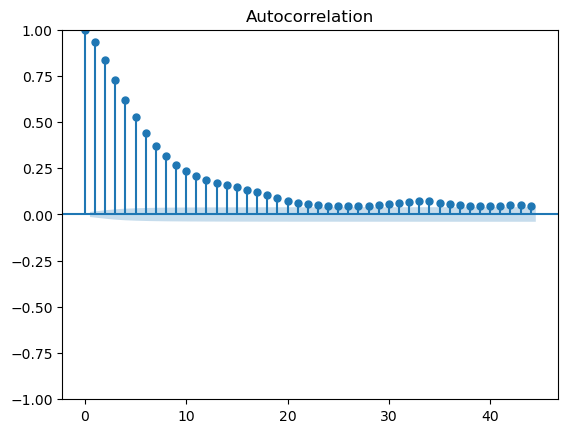

In [55]:
plot_acf(df_train_1_diff)

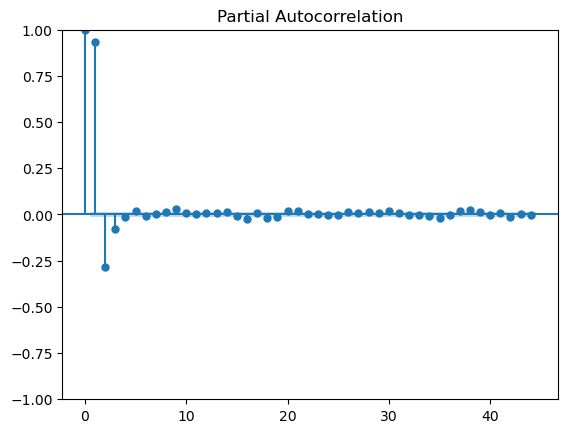

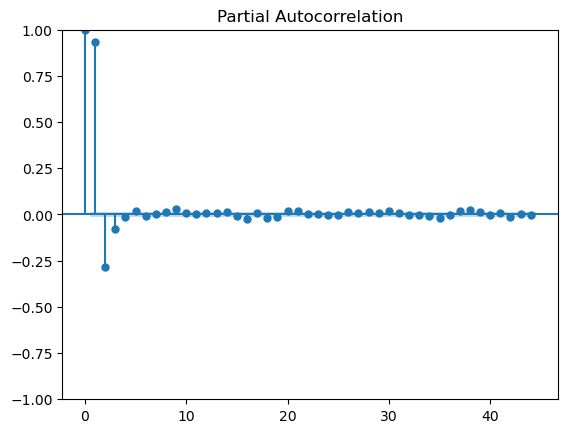

In [56]:
plot_pacf(df_train_1_diff)

In [59]:
print('For original dataset:')
adf_result = adfuller(df_train_1)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

kpss_result = kpss(df_train_1)
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

print('For differences:')
adf_result_diff = adfuller(df_train_1_diff)
print('ADF Statistic:', adf_result_diff[0])
print('p-value:', adf_result_diff[1])

kpss_result_diff = kpss(df_train_1_diff)
print('KPSS Statistic:', kpss_result_diff[0])
print('p-value:', kpss_result_diff[1])

For original dataset:
ADF Statistic: -20.172411456620335
p-value: 0.0
KPSS Statistic: 0.04347128761800392
p-value: 0.1
For differences:


C:\Users\Tom\AppData\Local\Temp\ipykernel_536\1588727145.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_train_1)


ADF Statistic: -17.926287045197075
p-value: 2.8940094535231604e-30
KPSS Statistic: 0.31883526139062907
p-value: 0.1


C:\Users\Tom\AppData\Local\Temp\ipykernel_536\1588727145.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(df_train_1_diff)


In [25]:
for i in range(-4,1):
    ts=pd.to_datetime('2017-05-07 00:00:00')+timedelta(weeks=i)
    ts_m5=ts-timedelta(minutes=5)
    y_tt=df_train_1.loc[:ts_m5]
    y_tt_diff=df_train_1_diff.loc[:ts_m5]
    y_ho=df_train_1.loc[ts:ts_m5+timedelta(weeks=1)]
    preds0=pd.Series(0.0,index=y_ho.index)
    for ind in preds0.index:
        preds0[ind]=np.array([y_tt[ind+timedelta(weeks=j)] for j in range(-10-i,-1)]).mean()
    model0_preds.append(preds0)
    #print('Model',1,'step',i+5)
    #mod1=auto_arima(y_tt,d=0,trace=True)
    mod1=auto_arima(y_tt,d=0)
    preds1=mod1.predict(2016)
    model1_preds.append(preds1)
    preds2=pd.Series(0.0,index=y_ho.index)
    #print('Model',2,'step',i+5)
    #mod2=auto_arima(y_tt_diff,d=0,trace=True)
    mod2=auto_arima(y_tt_diff,d=0)
    preds2_diff=mod2.predict(2016)
    for ind in preds2.index:
        preds2[ind]=y_tt[ind-timedelta(weeks=1)]+preds2_diff[ind]
    model2_preds.append(preds2)
    #print('Model',3,'step',i+5)
    #mod3=auto_arima(y_tt,d=0,seasonal=True,m=2016,trace=True)
    #preds3=mod1.predict(2016)
    #model3_preds.append(preds3)

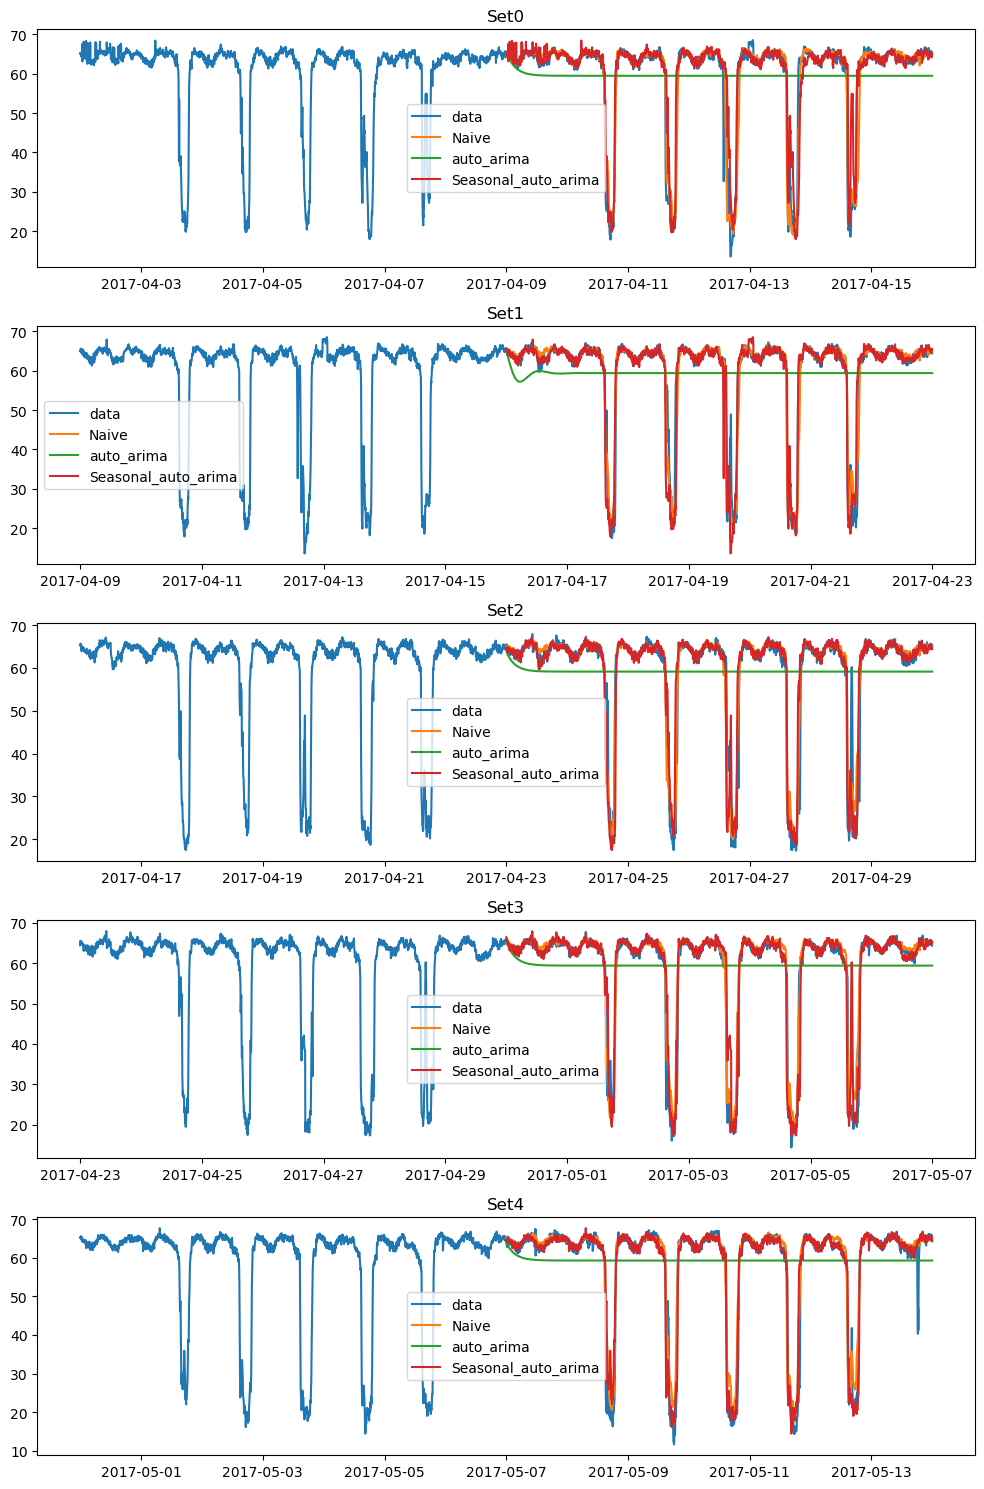

In [52]:
fig,axes=plt.subplots(5,1,figsize=(10,15))
for vset in range(5):
    ts=pd.to_datetime('2017-05-07 00:00:00')+timedelta(weeks=vset-4)
    ts_m5=ts-timedelta(minutes=5)
    data=df_train_1.loc[ts_m5-timedelta(weeks=1):ts_m5+timedelta(weeks=1)]
    range1=pd.date_range(start=ts_m5-timedelta(weeks=1),end=ts_m5+timedelta(weeks=1),freq='5min')
    range2=pd.date_range(start=ts,end=ts_m5+timedelta(weeks=1),freq='5min')
    ax=axes[vset]
    ax.plot(range1, data, label = 'data')
    ax.plot(range2, model0_preds[vset], label = 'Naive')
    ax.plot(range2, model1_preds[vset], label = 'auto_arima')
    ax.plot(range2, model2_preds[vset], label = 'Seasonal_auto_arima')
    ax.set_title(f'Set{vset}')
    ax.legend()
plt.tight_layout()
plt.show()

In [40]:
for i in range(5):
    print('Set',i)
    print('mse of model 0 is:',mse(actual[i],model0_preds[i]))
    print('mse of model 1 is:',mse(actual[i],model1_preds[i]))
    print('mse of model 2 is:',mse(actual[i],model2_preds[i]))

print('Average mse of model 0 is:',np.array([mse(actual[i],model0_preds[i]) for i in range(5)]).mean())
print('Average mse of model 1 is:',np.array([mse(actual[i],model1_preds[i]) for i in range(5)]).mean())
print('Average mse of model 2 is:',np.array([mse(actual[i],model2_preds[i]) for i in range(5)]).mean())

Set 0
mse of model 0 is: 15.819100595238098
mse of model 1 is: 163.7932889940496
mse of model 2 is: 24.75329123469812
Set 1
mse of model 0 is: 11.96309330908289
mse of model 1 is: 158.11384968390416
mse of model 2 is: 20.54726385390815
Set 2
mse of model 0 is: 16.637563066893424
mse of model 1 is: 166.64835458610827
mse of model 2 is: 25.69795348802706
Set 3
mse of model 0 is: 11.084598059275795
mse of model 1 is: 183.19777691862228
mse of model 2 is: 23.95682633121536
Set 4
mse of model 0 is: 14.013074294532629
mse of model 1 is: 204.7090614241721
mse of model 2 is: 13.893660162356113
Average mse of model 0 is: 13.903485865004566
Average mse of model 1 is: 175.29246632137128
Average mse of model 2 is: 21.76979901404096


In [31]:
model0_preds_2 = []
model1_preds_2 = []
model2_preds_2 = []
model3_preds_2 = []
for i in range(-4,1):
    ts=pd.to_datetime('2017-05-09 12:00:00')+timedelta(weeks=i)
    y_tt=df_train_1.loc[:ts]
    y_tt_diff=df_train_1_diff.loc[:ts]
    y_ho=df_train_1.loc[ts+timedelta(minutes=5):ts+timedelta(hours=1)]
    preds0=pd.Series(0.0,index=y_ho.index)
    for ind in preds0.index:
        preds0[ind]=np.array([y_tt[ind+timedelta(weeks=j)] for j in range(-10-i,-1)]).mean()
    model0_preds_2.append(preds0)
    mod1=auto_arima(y_tt,d=0)
    preds1=mod1.predict(12)
    model1_preds_2.append(preds1)
    preds2=pd.Series(0.0,index=y_ho.index)
    mod2=auto_arima(y_tt_diff,d=0)
    preds2_diff=mod2.predict(12)
    for ind in preds2.index:
        preds2[ind]=y_tt[ind-timedelta(weeks=1)]+preds2_diff[ind]
    model2_preds_2.append(preds2)

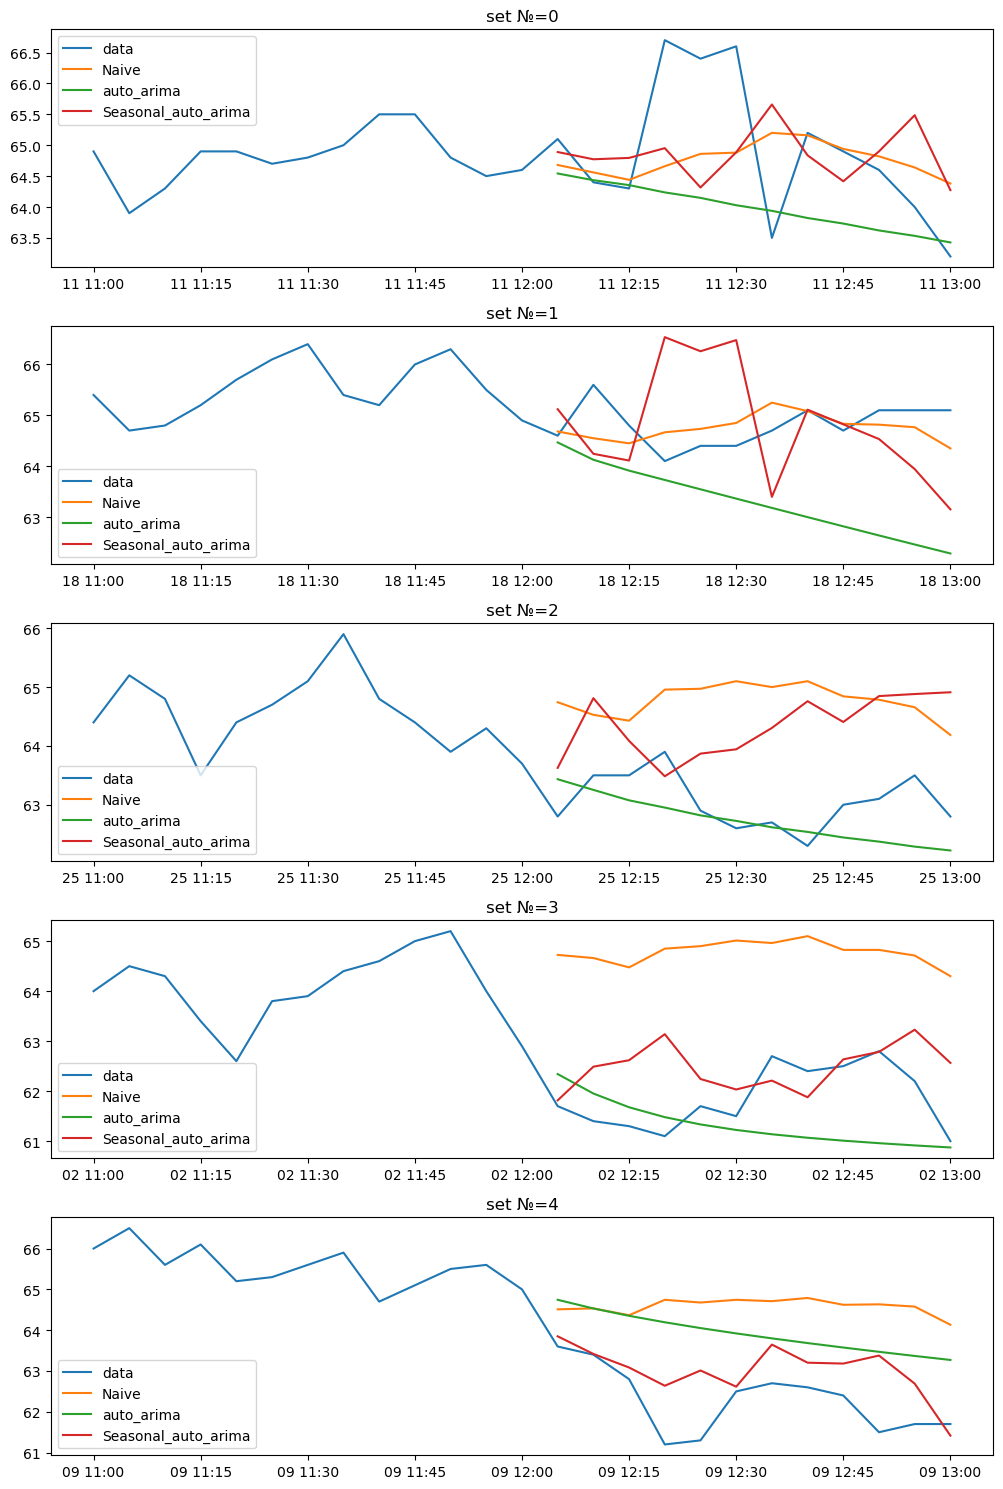

In [51]:
fig,axes=plt.subplots(5,1,figsize=(10, 15))
for vset in range(5):
    ts=pd.to_datetime('2017-05-09 12:05:00')+timedelta(weeks=vset-4)
    ts_m5=ts-timedelta(minutes=5)
    data=df_train_1.loc[ts_m5-timedelta(hours=1):ts_m5+timedelta(hours=1)]
    range1=pd.date_range(start=ts_m5-timedelta(hours=1),end=ts_m5+timedelta(hours=1),freq='5min')
    range2=pd.date_range(start=ts,end=ts_m5+timedelta(hours=1),freq='5min')
    ax=axes[vset]
    ax.plot(range1,data,label='data')
    ax.plot(range2,model0_preds_2[vset],label='Naive')
    ax.plot(range2,model1_preds_2[vset],label='auto_arima')
    ax.plot(range2,model2_preds_2[vset],label='Seasonal_auto_arima')
    ax.set_title(f'Set={vset}')
    ax.legend()

plt.tight_layout()
plt.show()

In [41]:
actual_2=[]
for i in range(5):
    ts=pd.to_datetime('2017-05-09 12:05:00')+timedelta(weeks=i-4)
    ts_m5=ts-timedelta(minutes=5)
    actual_2.append(df_train_1.loc[ts:ts_m5+timedelta(hours=1)])
for i in range(5):
    print('Set',i+1)
    print('mse of model 0 is:',mse(actual_2[i],model0_preds_2[i]))
    print('mse of model 1 is:',mse(actual_2[i],model1_preds_2[i]))
    print('mse of model 2 is:',mse(actual_2[i],model2_preds_2[i]))

print('Average mse of model 0 is:',np.array([mse(actual_2[i],model0_preds_2[i]) for i in range(5)]).mean())
print('Average mse of model 1 is:',np.array([mse(actual_2[i],model1_preds_2[i]) for i in range(5)]).mean())
print('Average mse of model 2 is:',np.array([mse(actual_2[i],model2_preds_2[i]) for i in range(5)]).mean())

Set 1
mse of model 0 is: 1.2047333333333397
mse of model 1 is: 1.8955537272979701
mse of model 2 is: 1.603294661108056
Set 2
mse of model 0 is: 0.245092592592587
mse of model 1 is: 3.012833859495119
mse of model 2 is: 1.9571190129479195
Set 3
mse of model 0 is: 3.3316836734693758
mse of model 1 is: 0.3555483623260311
mse of model 2 is: 2.1413100004368166
Set 4
mse of model 0 is: 8.802760416666663
mse of model 1 is: 1.0585779007006997
mse of model 2 is: 0.9765781207515948
Set 5
mse of model 0 is: 5.94779835390946
mse of model 1 is: 3.037807465852732
mse of model 2 is: 0.9684975788628565
Average mse of model 0 is: 3.9064136739942854
Average mse of model 1 is: 1.8720642631345104
Average mse of model 2 is: 1.5293598748214485
